In [1]:
import os
import torch
import torchvision
import tarfile
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as tt
from torch.utils.data import random_split
from torchvision.utils import make_grid
import torchvision.models as models
import torch.optim as optim
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import opendatasets as od
matplotlib.rcParams['figure.facecolor'] = '#ffffff'

In [2]:
# Dowload the dataset
dataset_url = "https://s3.amazonaws.com/fast-ai-imageclas/cifar100.tgz"
download_url(dataset_url, '.')

Using downloaded and verified file: .\cifar100.tgz


In [3]:
# Extract from archive
with tarfile.open('./cifar100.tgz', 'r:gz') as tar:
    tar.extractall(path='./data')
data_dir = './data/cifar100'

print(os.listdir(data_dir))
classes = os.listdir(data_dir + "/train")
print(classes)

['test', 'train']
['aquatic_mammals', 'fish', 'flowers', 'food_containers', 'fruit_and_vegetables', 'household_electrical_devices', 'household_furniture', 'insects', 'large_carnivores', 'large_man-made_outdoor_things', 'large_natural_outdoor_scenes', 'large_omnivores_and_herbivores', 'medium_mammals', 'non-insect_invertebrates', 'people', 'reptiles', 'small_mammals', 'trees', 'vehicles_1', 'vehicles_2']


In [4]:
# Data transforms (normalization & data augmentation)
stats = ((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
train_tfms = tt.Compose([tt.RandomCrop(32, padding=4, padding_mode='reflect'), 
                         tt.RandomHorizontalFlip(), 
                         # tt.RandomRotate
                         # tt.RandomResizedCrop(256, scale=(0.5,0.9), ratio=(1, 1)), 
                         # tt.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
                         tt.ToTensor(), 
                         tt.Normalize(*stats,inplace=True)])
valid_tfms = tt.Compose([tt.ToTensor(), tt.Normalize(*stats)])

In [5]:
# PyTorch datasets
train_ds = ImageFolder(data_dir+'/train', train_tfms)
valid_ds = ImageFolder(data_dir+'/test', valid_tfms)

In [6]:
# PyTorch data loaders
batch_size=64
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)
valid_dl = DataLoader(valid_ds, batch_size*2, num_workers=3, pin_memory=True)

In [7]:
valid_dl

In [8]:
def denormalize(images, means, stds):
    means = torch.tensor(means).reshape(1, 3, 1, 1)
    stds = torch.tensor(stds).reshape(1, 3, 1, 1)
    return images * stds + means

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        denorm_images = denormalize(images, *stats)
        ax.imshow(make_grid(denorm_images[:64], nrow=8).permute(1, 2, 0).clamp(0,1))
        break

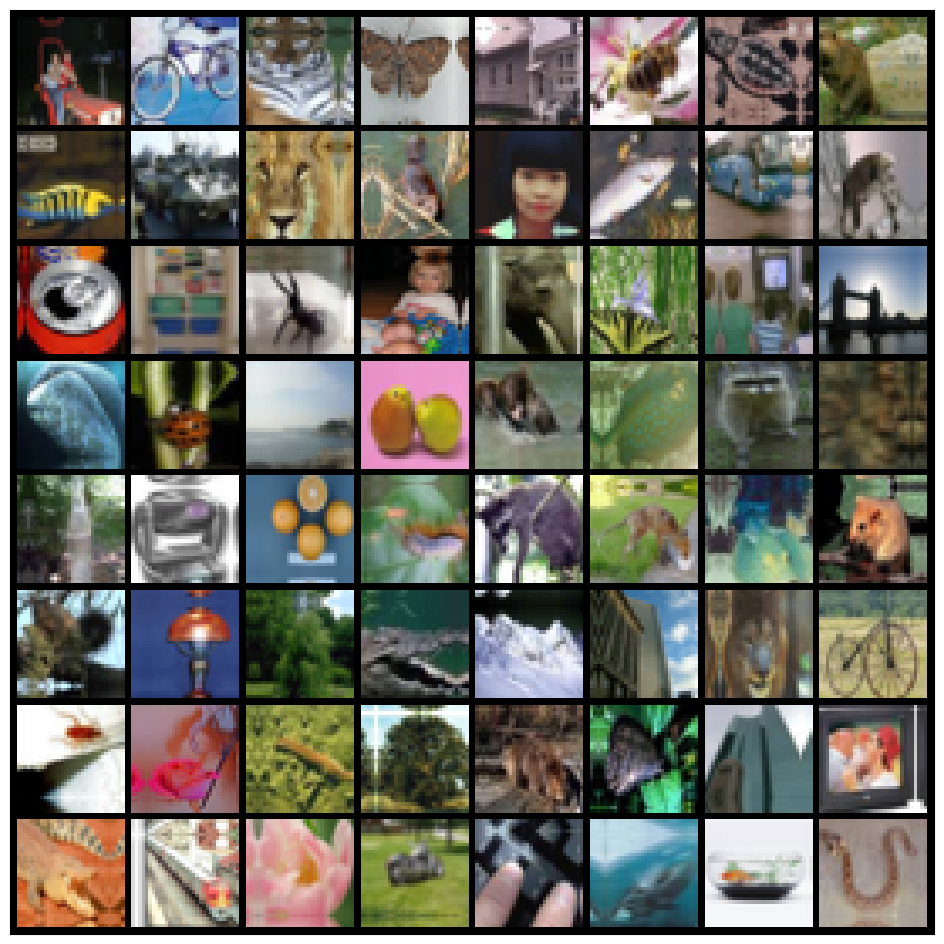

In [9]:
show_batch(train_dl)

In [10]:
input_image = valid_ds[1000][0].unsqueeze(0)  # torch.rand(1, 1, 28, 2)
input_image

tensor([[[[2.5141, 2.5141, 2.5141,  ..., 2.5141, 2.5141, 2.5141],
          [2.4365, 2.4947, 2.4753,  ..., 2.4947, 2.4947, 2.4947],
          [2.4365, 2.5141, 2.4947,  ..., 2.4947, 2.4947, 2.4947],
          ...,
          [2.3784, 2.4947, 2.4947,  ..., 2.4753, 2.4947, 2.4947],
          [2.4365, 2.5141, 2.4947,  ..., 2.4947, 2.4947, 2.4947],
          [2.5141, 2.5141, 2.5141,  ..., 2.5141, 2.5141, 2.5141]],

         [[2.5968, 2.5968, 2.5968,  ..., 2.5968, 2.5968, 2.5968],
          [2.5181, 2.5771, 2.5575,  ..., 2.5771, 2.5771, 2.5771],
          [2.5181, 2.5968, 2.5771,  ..., 2.5771, 2.5771, 2.5771],
          ...,
          [2.5181, 2.5575, 2.5378,  ..., 2.5575, 2.5771, 2.5771],
          [2.5378, 2.5968, 2.5575,  ..., 2.5771, 2.5771, 2.5771],
          [2.5771, 2.5968, 2.5968,  ..., 2.5968, 2.5968, 2.5968]],

         [[2.7537, 2.7537, 2.7537,  ..., 2.7537, 2.7537, 2.7537],
          [2.6757, 2.7342, 2.7147,  ..., 2.7342, 2.7342, 2.7342],
          [2.6757, 2.7537, 2.7342,  ..., 2

In [ ]:
class LeNet5(nn.Module):
    def __init__(self):
        super(LeNet5, self).__init__()
        # Convolutional layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5, padding=2)
        self.pool1 = nn.AvgPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)
        self.pool2 = nn.AvgPool2d(kernel_size=2, stride=2)
        self.conv3 = nn.Conv2d(in_channels=16, out_channels=120, kernel_size=5)

        # Fully connected layers
        self.fc1 = nn.Linear(in_features=480, out_features=84)  
        self.fc2 = nn.Linear(in_features=84, out_features=20)

    def forward(self, x):
        conv1_out = torch.tanh(self.conv1(x))
        pool1_out = self.pool1(conv1_out)
        conv2_out = torch.tanh(self.conv2(pool1_out))
        pool2_out = self.pool2(conv2_out)
        conv3_out = torch.tanh(self.conv3(pool2_out))

        # Asegurar que el tamaño sea correcto
        x_flatten = conv3_out.view(conv3_out.size(0), -1)  
        #print(f"Flattened size: {x_flatten.shape}")  
        if x_flatten.size(1) != self.fc1.in_features:
            self.fc1 = nn.Linear(x_flatten.size(1), 84) 
        
        fc1_out = torch.tanh(self.fc1(x_flatten))
        output = torch.softmax(self.fc2(fc1_out), dim=1)

        return conv1_out, pool1_out, conv2_out, pool2_out, conv3_out, fc1_out, output


In [12]:
class LeNet5_ExtraConv(nn.Module):
    def __init__(self):
        super(LeNet5_ExtraConv, self).__init__()
        # Convolutional layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5, stride=1, padding=2)  # Output: 6x32x32
        self.pool1 = nn.AvgPool2d(kernel_size=2, stride=2)  # Output: 6x16x16
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1, padding=0)  # Output: 16x12x12
        self.conv_extra = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=0)  # Output: 32x10x10
        self.pool2 = nn.AvgPool2d(kernel_size=2, stride=2)  # Output: 32x5x5

        # Fully connected layers
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=120, kernel_size=5, stride=1, padding=0)  # Output: 120x1x1
        self.fc1 = nn.Linear(in_features=120, out_features=84)  # Output: 84
        self.fc2 = nn.Linear(in_features=84, out_features=20)  # Salida para 20 superclases

    def forward(self, x):
        conv1_out = torch.tanh(self.conv1(x))
        pool1_out = self.pool1(conv1_out)
        conv2_out = torch.tanh(self.conv2(pool1_out))
        conv_extra_out = torch.tanh(self.conv_extra(conv2_out))
        pool2_out = self.pool2(conv_extra_out)
        conv3_out = torch.tanh(self.conv3(pool2_out))
        x_flatten = conv3_out.view(conv3_out.size(0), -1)
        fc1_out = torch.tanh(self.fc1(x_flatten))
        output = torch.softmax(self.fc2(fc1_out), dim=1)

        return conv1_out, pool1_out, conv2_out, conv_extra_out, pool2_out, conv3_out, fc1_out, output


In [13]:
class LeNet5_Optimized(nn.Module):
    def __init__(self):
        super(LeNet5_Optimized, self).__init__()
        # Convolutional layers
        self.conv1 = nn.Conv2d(3, 16, kernel_size=5, stride=1, padding=2)
        self.bn1 = nn.BatchNorm2d(16)
        self.pool1 = nn.MaxPool2d(2, 2)

        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=0)
        self.bn2 = nn.BatchNorm2d(32)

        self.conv_extra = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=0)
        self.bn_extra = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(2, 2)

        self.conv3 = nn.Conv2d(64, 120, kernel_size=5, stride=1, padding=0)

        # Fully connected layers
        self.fc1 = nn.Linear(120, 84)
        self.fc2 = nn.Linear(84, 20)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        conv1_out = torch.relu(self.bn1(self.conv1(x)))
        pool1_out = self.pool1(conv1_out)

        conv2_out = torch.relu(self.bn2(self.conv2(pool1_out)))
        conv_extra_out = torch.relu(self.bn_extra(self.conv_extra(conv2_out)))
        pool2_out = self.pool2(conv_extra_out)

        conv3_out = torch.relu(self.conv3(pool2_out))
        x_flatten = conv3_out.view(conv3_out.size(0), -1)

        fc1_out = self.dropout(torch.relu(self.fc1(x_flatten)))
        output = torch.softmax(self.fc2(fc1_out), dim=1)

        return conv1_out, pool1_out, conv2_out, conv_extra_out, pool2_out, conv3_out, fc1_out, output


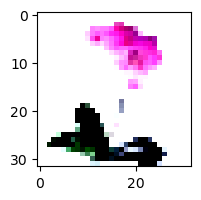

In [14]:
img, label = valid_ds[1000]
plt.figure(figsize=(2,2))
plt.imshow(img.permute(1, 2, 0).clamp(0, 1))


In [15]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

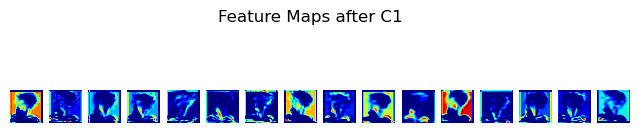

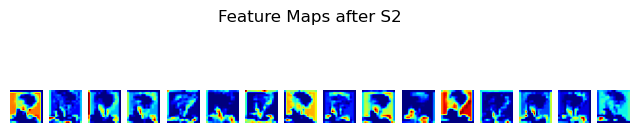

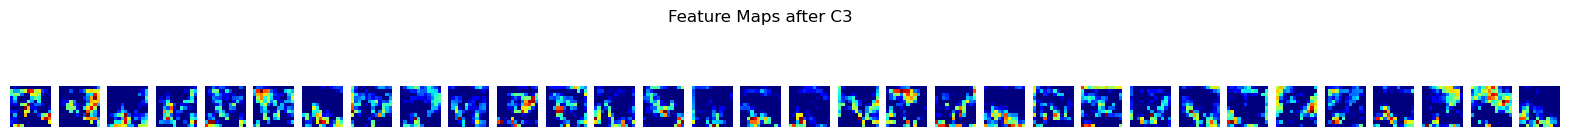

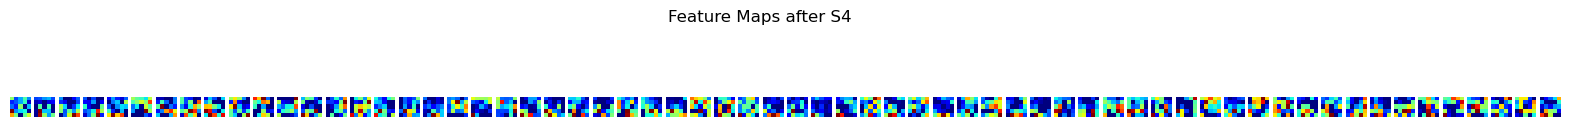

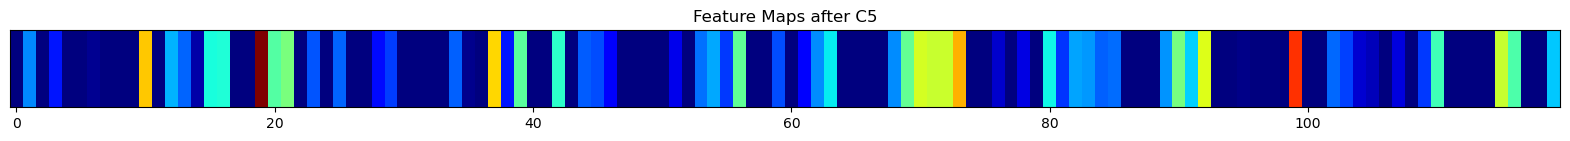

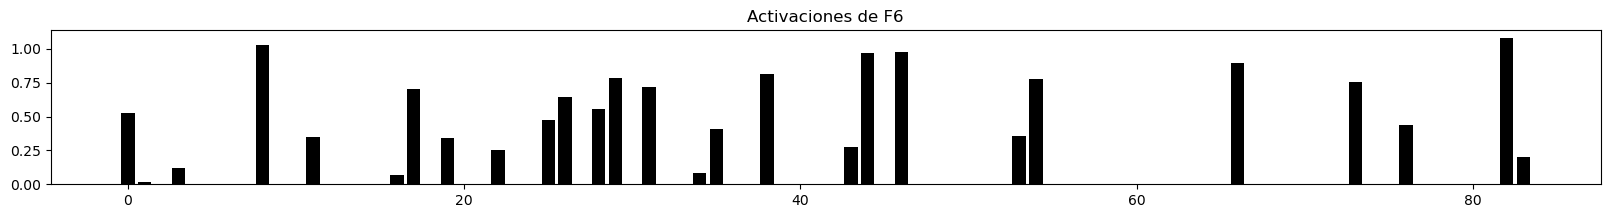

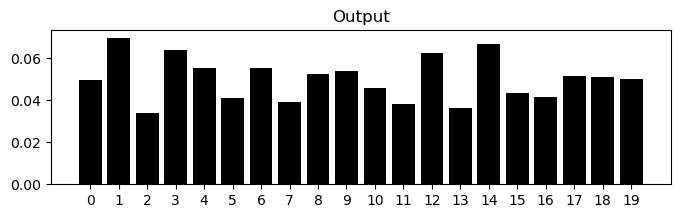

In [16]:
# model = LeNet5()
# conv1_out, pool1_out, conv2_out, pool2_out, conv3_out, fc1_out, output = model(input_image)

# model = LeNet5_ExtraConv()
model = LeNet5_Optimized()
conv1_out, pool1_out, conv2_out, conv_extra_out, pool2_out, conv3_out, fc1_out, output = model(input_image)



def visualize_feature_maps(feature_maps, title, x, y):
    num_maps = feature_maps.shape[1]
    fig, axes = plt.subplots(1, num_maps, figsize=(x, y))
    for i in range(num_maps):
        axes[i].imshow(feature_maps[0, i].detach().numpy(), cmap='jet')
        axes[i].axis('off')
    plt.suptitle(title)
    plt.show()

visualize_feature_maps(conv1_out, 'Feature Maps after C1', x=8, y=2)  
visualize_feature_maps(pool1_out, 'Feature Maps after S2', x=8, y=2)
visualize_feature_maps(conv2_out, 'Feature Maps after C3', x=20, y=2)
visualize_feature_maps(pool2_out, 'Feature Maps after S4', x=20, y=2)

conv3_out_flat = conv3_out.view(-1).detach().numpy()
plt.figure(figsize=(20, 1))  
plt.imshow(conv3_out_flat[np.newaxis, :], cmap='jet', aspect='auto') 
plt.title('Feature Maps after C5')
plt.yticks([])  
plt.show()

plt.figure(figsize=(20, 2))
plt.bar(range(len(fc1_out[0])), fc1_out[0].detach().numpy(), color='k')
plt.title('Activaciones de F6')
plt.show()

plt.figure(figsize=(8, 2))
plt.bar(range(len(output[0])), output[0].detach().numpy(), color='k')
plt.title('Output')
plt.xticks(np.arange(0, 20, 1))
plt.show()

In [17]:
# model = LeNet5()
# model = LeNet5_ExtraConv()
model = LeNet5_Optimized()
model.to(device)

LeNet5_Optimized(
  (conv1): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_extra): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (bn_extra): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 120, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=120, out_features=84, bias=True)
  (fc2): Linear(in_features=84, out_features=20, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

In [18]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
num_epochs = 30

# Listas para almacenar las métricas
train_loss_list = []
test_loss_list = []
train_accuracy_list = []
test_accuracy_list = []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    correct_train = 0
    total_train = 0
    
    # Entrenamiento
    for images, labels in train_dl:
        images, labels = images.to(device), labels.to(device)
        
        # Forward
        _, _, _, _, _, _, _, outputs = model(images) 
        loss = criterion(outputs, labels)
        
        # Backpropagation y optimización
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        
        # Predicciones correctas
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
    
    # Calcular métricas de entrenamiento
    train_loss_list.append(train_loss / len(train_dl))
    train_accuracy_list.append(100 * correct_train / total_train)
    
    # Validación
    model.eval()
    test_loss = 0
    correct_test = 0
    total_test = 0
    
    with torch.no_grad():
        for images, labels in valid_dl:
            images, labels = images.to(device), labels.to(device)
            
            # Forward
            _, _, _, _, _, _, _, outputs = model(images)
            loss = criterion(outputs, labels)
            
            test_loss += loss.item()
            
            # Predicciones correctas
            _, predicted = torch.max(outputs.data, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()
    
    # Calcular métricas de validación
    test_loss_list.append(test_loss / len(valid_dl))
    test_accuracy_list.append(100 * correct_test / total_test)
    
    # Imprimir resultados de la época
    print(f'Epoch [{epoch+1}/{num_epochs}], '
          f'Train Loss: {train_loss_list[-1]:.4f}, '
          f'Train Accuracy: {train_accuracy_list[-1]:.2f}%, '
          f'Test Loss: {test_loss_list[-1]:.4f}, '
          f'Test Accuracy: {test_accuracy_list[-1]:.2f}%')

Epoch [1/30], Train Loss: 2.9093, Train Accuracy: 16.08%, Test Loss: 2.8629, Test Accuracy: 21.24%
Epoch [2/30], Train Loss: 2.8598, Train Accuracy: 21.47%, Test Loss: 2.8347, Test Accuracy: 24.18%
Epoch [3/30], Train Loss: 2.8382, Train Accuracy: 23.67%, Test Loss: 2.8272, Test Accuracy: 24.86%
Epoch [4/30], Train Loss: 2.8278, Train Accuracy: 24.67%, Test Loss: 2.8161, Test Accuracy: 26.15%
Epoch [5/30], Train Loss: 2.8229, Train Accuracy: 25.27%, Test Loss: 2.8052, Test Accuracy: 27.25%
Epoch [6/30], Train Loss: 2.8155, Train Accuracy: 25.98%, Test Loss: 2.8019, Test Accuracy: 27.67%
Epoch [7/30], Train Loss: 2.8024, Train Accuracy: 27.35%, Test Loss: 2.7967, Test Accuracy: 28.20%
Epoch [8/30], Train Loss: 2.7970, Train Accuracy: 27.86%, Test Loss: 2.7798, Test Accuracy: 29.90%
Epoch [9/30], Train Loss: 2.7905, Train Accuracy: 28.49%, Test Loss: 2.7774, Test Accuracy: 30.17%
Epoch [10/30], Train Loss: 2.7850, Train Accuracy: 29.07%, Test Loss: 2.7655, Test Accuracy: 31.36%
Epoch [11

True: aquatic_mammals
Pred: large_man-made_outdoor_things


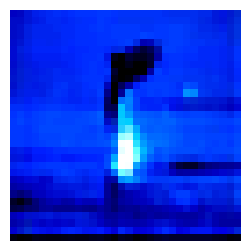

In [19]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    _, _, _, _, _, _, _, yb = model(xb)  
    # Pick index with highest probability
    _, preds = torch.max(yb, dim=1)
    return preds[0].item() 


img, label = valid_ds[100]

predicted_class_idx = predict_image(img, model)
predicted_class = train_ds.classes[predicted_class_idx]
true_class = train_ds.classes[label]

plt.figure(figsize=(3, 3))
plt.imshow(img.permute(1, 2, 0).clamp(0, 1))  
print(f"True: {true_class}\nPred: {predicted_class}")
plt.axis('off')
plt.show()

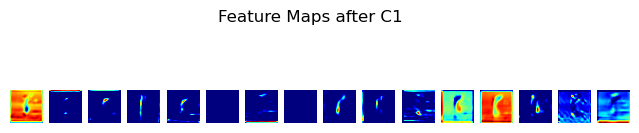

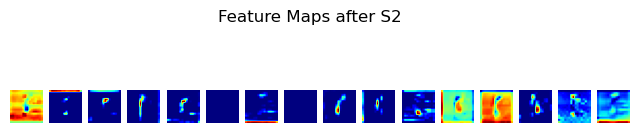

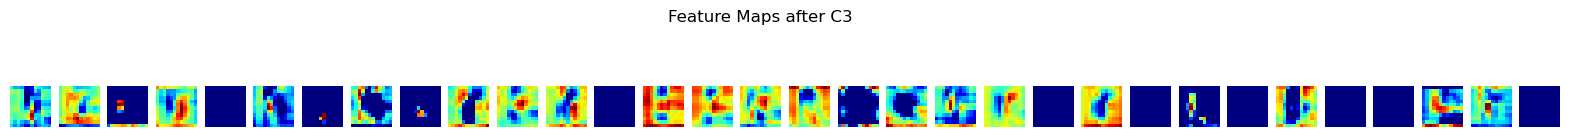

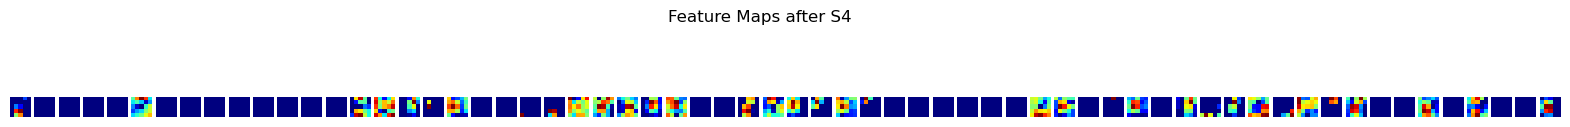

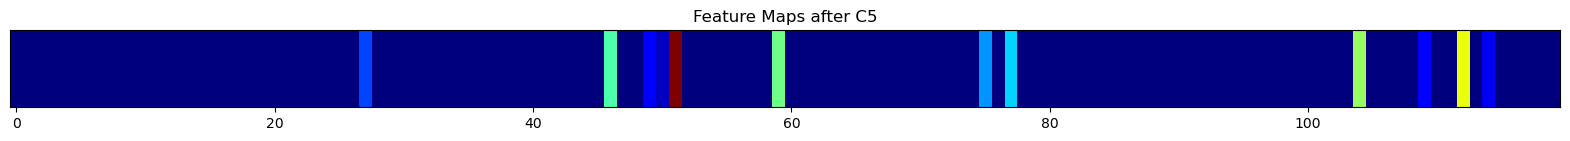

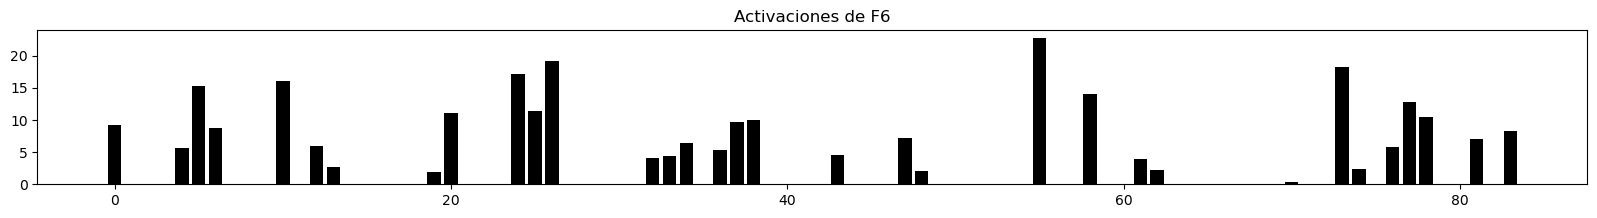

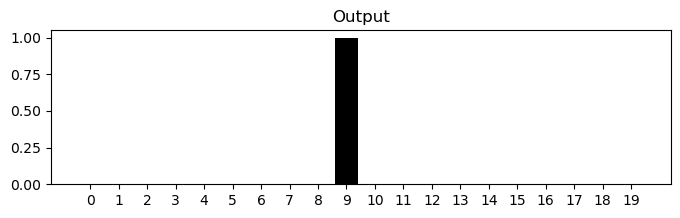

In [20]:
model.to(device)
input_image = img.unsqueeze(0).to(device)  

conv1_out, pool1_out, conv2_out, conv_extra_out, pool2_out, conv3_out, fc1_out, output = model(input_image)

def visualize_feature_maps(feature_maps, title, x, y):
    num_maps = feature_maps.shape[1]
    fig, axes = plt.subplots(1, num_maps, figsize=(x, y))
    for i in range(num_maps):
        axes[i].imshow(feature_maps[0, i].detach().cpu().numpy(), cmap='jet')  # Mover a CPU para visualizar
        axes[i].axis('off')
    plt.suptitle(title)
    plt.show()

visualize_feature_maps(conv1_out, 'Feature Maps after C1', x=8, y=2)  
visualize_feature_maps(pool1_out, 'Feature Maps after S2', x=8, y=2)
visualize_feature_maps(conv2_out, 'Feature Maps after C3', x=20, y=2)
visualize_feature_maps(pool2_out, 'Feature Maps after S4', x=20, y=2)

conv3_out_flat = conv3_out.view(-1).detach().cpu().numpy()  
plt.figure(figsize=(20, 1))  
plt.imshow(conv3_out_flat[np.newaxis, :], cmap='jet', aspect='auto') 
plt.title('Feature Maps after C5')
plt.yticks([])  
plt.show()

plt.figure(figsize=(20, 2))
plt.bar(range(len(fc1_out[0])), fc1_out[0].detach().cpu().numpy(), color='k')  
plt.title('Activaciones de F6')
plt.show()

plt.figure(figsize=(8, 2))
plt.bar(range(len(output[0])), output[0].detach().cpu().numpy(), color='k')  
plt.title('Output')
plt.xticks(np.arange(0, 20, 1))
plt.show()


In [21]:
from sklearn.neighbors import NearestNeighbors

def compute_recall_nn(data_loader, model, device, k=5):
    """
    Compute Recall using Nearest Neighbors in pixel space.

    Parameters:
        data_loader (DataLoader): DataLoader with images and labels.
        model (torch.nn.Module): Model for feature extraction.
        device (torch.device): Device to use (CPU or GPU).
        k (int): Number of nearest neighbors.

    Returns:
        recall (float): Recall score based on nearest neighbors.
    """
    model.eval()
    images = []
    labels = []

    # Extract images and labels from DataLoader
    with torch.no_grad():
        for img_batch, label_batch in data_loader:
            images.append(img_batch.view(img_batch.size(0), -1))  # Flatten images
            labels.append(label_batch)

    images = torch.cat(images, dim=0).cpu().numpy()  # All images as vectors
    labels = torch.cat(labels, dim=0).cpu().numpy()  # All labels

    # Nearest Neighbors
    nbrs = NearestNeighbors(n_neighbors=k + 1, metric='euclidean').fit(images)  # +1 for self-neighbor
    distances, indices = nbrs.kneighbors(images)

    # Calculate recall
    recall_count = 0
    for i, neighbors in enumerate(indices):
        # Ignore self-neighbor (neighbors[0] is the same image)
        relevant = sum(labels[neighbor] == labels[i] for neighbor in neighbors[1:])
        if relevant > 0:  # At least one relevant neighbor
            recall_count += 1

    recall = recall_count / len(labels)
    return recall


In [22]:
recall = compute_recall_nn(train_dl, model, device, k=5)
print(f"Recall using Nearest Neighbors (k=5): {recall:.4f}")

Recall using Nearest Neighbors (k=5): 0.4304


In [ ]:
def visualize_nn_results(data_loader, k=5, num_samples=5):
    images = []
    labels = []

    # Extract images and labels from DataLoader
    for img_batch, label_batch in data_loader:
        images.append(img_batch.view(img_batch.size(0), -1))  # Flatten images
        labels.append(label_batch)

    images = torch.cat(images, dim=0).cpu().numpy()  # All images as vectors
    labels = torch.cat(labels, dim=0).cpu().numpy()  # All labels

    # Fit Nearest Neighbors
    nbrs = NearestNeighbors(n_neighbors=k + 1, metric='euclidean').fit(images)  # +1 for self-neighbor
    distances, indices = nbrs.kneighbors(images)

    # Randomly select images to visualize
    sample_indices = np.random.choice(len(images), num_samples, replace=False)

    # Visualization
    for idx in sample_indices:
        plt.figure(figsize=(15, 3))
        
        # Original image
        original_image = images[idx].reshape(3, 32, 32).transpose(1, 2, 0)
        plt.subplot(1, k + 2, 1)
        plt.imshow((original_image * 0.5 + 0.5))  # Undo normalization
        plt.title(f"Original\nClass: {labels[idx]}")
        plt.axis('off')

        # Nearest neighbors
        for neighbor_idx, neighbor in enumerate(indices[idx][1:]):  # Skip self-neighbor
            neighbor_image = images[neighbor].reshape(3, 32, 32).transpose(1, 2, 0)
            plt.subplot(1, k + 2, neighbor_idx + 2)
            plt.imshow((neighbor_image * 0.5 + 0.5))  # Undo normalization
            plt.title(f"Neighbor {neighbor_idx + 1}\nClass: {labels[neighbor]}")
            plt.axis('off')
        
        plt.tight_layout()
        plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


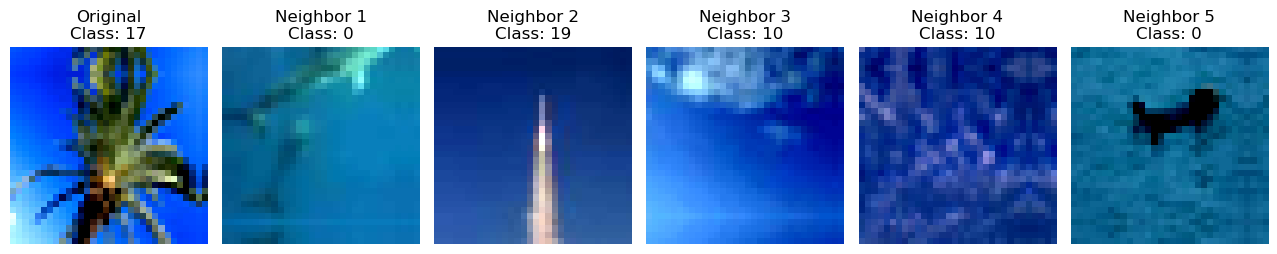

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


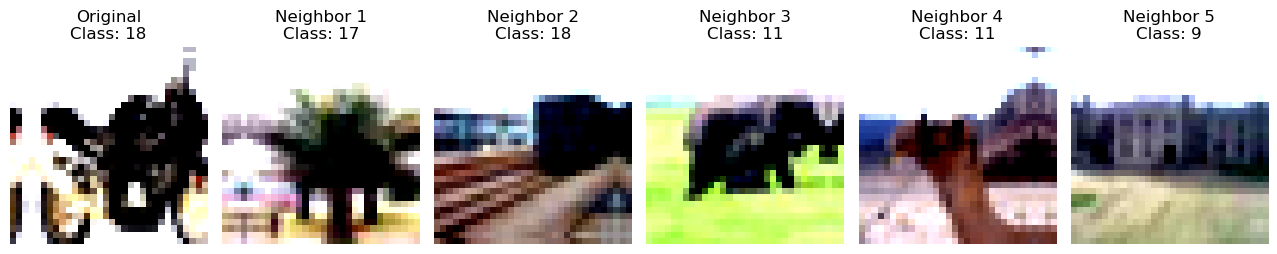

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


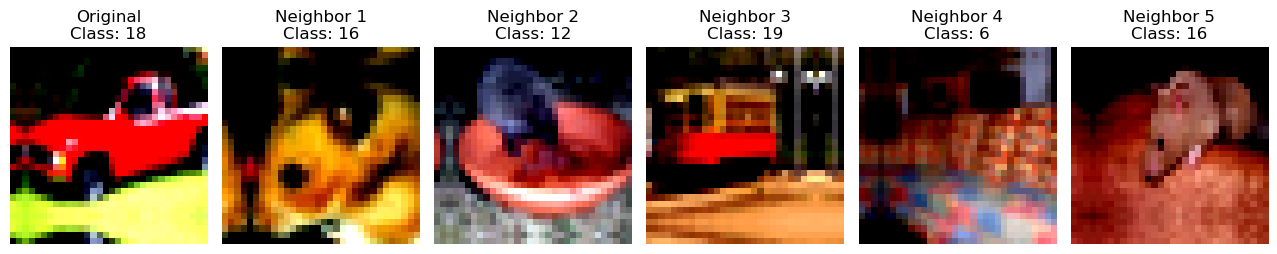

In [24]:
visualize_nn_results(train_dl, k=5, num_samples=3)

In [25]:
def extract_features(data_loader, model, device):
    model.eval()
    features = []
    labels = []

    with torch.no_grad():
        for images, label_batch in data_loader:
            images = images.to(device)
            
            # Extraer las características del modelo
            _, _, _, _, _, _, fc1_out, _ = model(images)
            
            features.append(fc1_out.cpu().numpy())
            labels.append(label_batch.cpu().numpy())

    features = np.concatenate(features, axis=0)
    labels = np.concatenate(labels, axis=0)
    return features, labels

def visualize_nn_features(features, labels, data_loader, k=5, num_samples=5):
    # Ajustar modelo de vecinos más cercanos
    nbrs = NearestNeighbors(n_neighbors=k + 1, metric='euclidean').fit(features)  # +1 para incluir el propio punto
    distances, indices = nbrs.kneighbors(features)

    all_images = []
    for images, _ in data_loader:
        all_images.append(images)
    all_images = torch.cat(all_images, dim=0).numpy()

    sample_indices = np.random.choice(len(features), num_samples, replace=False)

    for idx in sample_indices:
        plt.figure(figsize=(15, 3))
        
        original_image = all_images[idx].transpose(1, 2, 0) * 0.5 + 0.5  # Desnormalizar
        plt.subplot(1, k + 2, 1)
        plt.imshow(original_image)
        plt.title(f"Original\nClass: {labels[idx]}")
        plt.axis('off')

        for neighbor_idx, neighbor in enumerate(indices[idx][1:]):  # Ignorar el propio punto
            neighbor_image = all_images[neighbor].transpose(1, 2, 0) * 0.5 + 0.5  # Desnormalizar
            plt.subplot(1, k + 2, neighbor_idx + 2)
            plt.imshow(neighbor_image)
            plt.title(f"Neighbor {neighbor_idx + 1}\nClass: {labels[neighbor]}")
            plt.axis('off')
        
        plt.tight_layout()
        plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


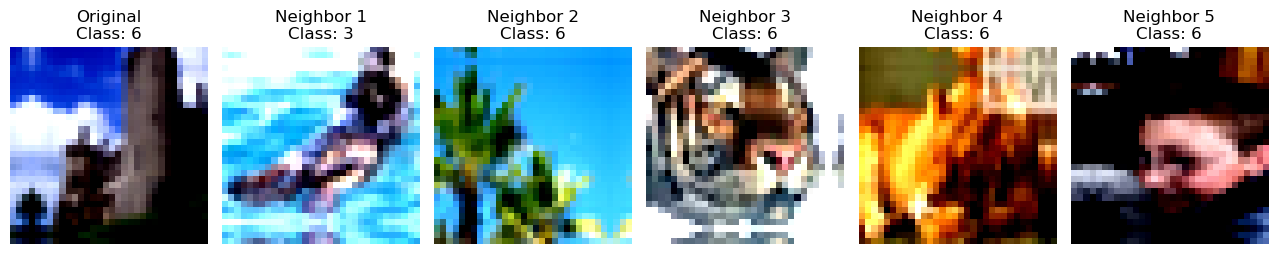

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


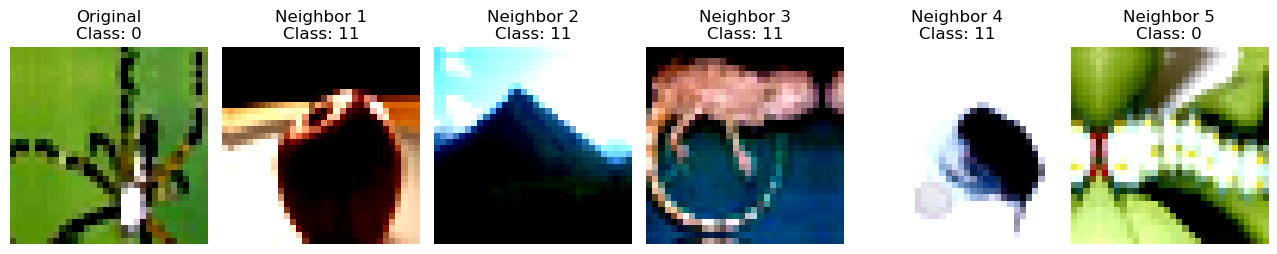

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


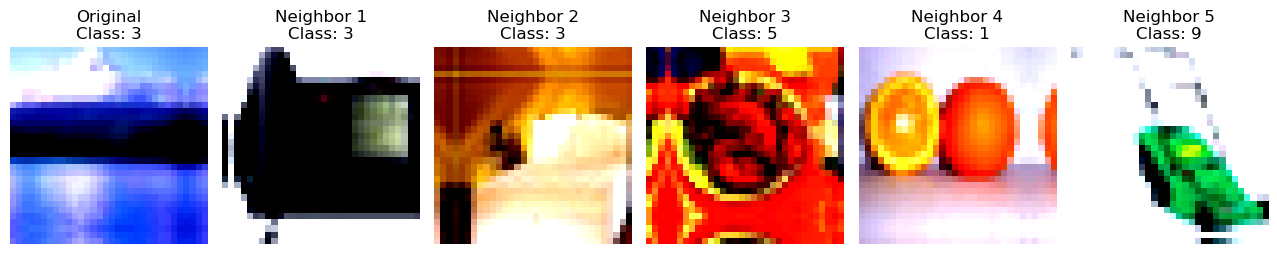

In [26]:
features, labels = extract_features(train_dl, model, device)
visualize_nn_features(features, labels, train_dl, k=5, num_samples=3)

### ResNet

In [27]:
class ResNetCustom(nn.Module):
    def __init__(self, num_classes=20):
        super(ResNetCustom, self).__init__()
        # We can load ResNet-18 prentrained
        self.resnet = models.resnet18(weights='IMAGENET1K_V1') 
        
        # Adaptation to CIFAR-100 (images of 32x32)
        self.resnet.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.resnet.maxpool = nn.Identity()  
        
        self.layer1 = self.resnet.layer1
        self.layer2 = self.resnet.layer2
        self.layer3 = self.resnet.layer3
        self.layer4 = self.resnet.layer4

        self.resnet.fc = nn.Linear(self.resnet.fc.in_features, num_classes)

    def forward(self, x):
        x = self.resnet.conv1(x)
        x = self.resnet.bn1(x)
        x = self.resnet.relu(x)
        
        x1 = self.layer1(x)
        x2 = self.layer2(x1)
        x3 = self.layer3(x2)
        x4 = self.layer4(x3)

        x_avg = self.resnet.avgpool(x4)
        x_flatten = torch.flatten(x_avg, 1)
        output = self.resnet.fc(x_flatten)

        return x1, x2, x3, x4, output


In [28]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ResNetCustom(num_classes=20).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    correct_train = 0
    total_train = 0

    for images, labels in train_dl:
        images, labels = images.to(device), labels.to(device)

        x1, x2, x3, x4, outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total_train += labels.size(0)
        correct_train += predicted.eq(labels).sum().item()

    scheduler.step()
    train_acc = 100. * correct_train / total_train
    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {train_loss / len(train_dl):.4f}, Accuracy: {train_acc:.2f}%")


Epoch 1/10, Loss: 1.5039, Accuracy: 53.54%
Epoch 2/10, Loss: 0.8977, Accuracy: 71.40%
Epoch 3/10, Loss: 0.7262, Accuracy: 76.78%
Epoch 4/10, Loss: 0.6324, Accuracy: 79.73%
Epoch 5/10, Loss: 0.5556, Accuracy: 81.97%
Epoch 6/10, Loss: 0.5195, Accuracy: 82.81%
Epoch 7/10, Loss: 0.4720, Accuracy: 84.60%
Epoch 8/10, Loss: 0.4452, Accuracy: 85.44%
Epoch 9/10, Loss: 0.4124, Accuracy: 86.47%
Epoch 10/10, Loss: 0.3868, Accuracy: 87.04%


True: aquatic_mammals
Pred: aquatic_mammals


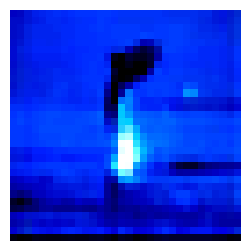

In [40]:
img, label = valid_ds[100]


def predict_image(img, model):
    xb = to_device(img.unsqueeze(0), device)
    _, _, _, _, yb = model(xb)  
    _, preds = torch.max(yb, dim=1)
    return preds[0].item() 


predicted_class_idx = predict_image(img, model)
predicted_class = train_ds.classes[predicted_class_idx]
true_class = train_ds.classes[label]

plt.figure(figsize=(3, 3))
plt.imshow(img.permute(1, 2, 0).clamp(0, 1))  
print(f"True: {true_class}\nPred: {predicted_class}")
plt.axis('off')
plt.show()

In [30]:
model.to(device)
# input_image = img.unsqueeze(0).to(device)  
input_image = img.unsqueeze(0).to(device)  

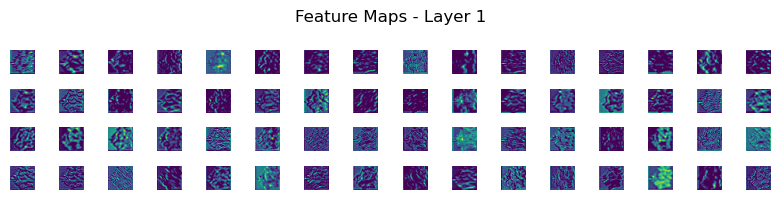

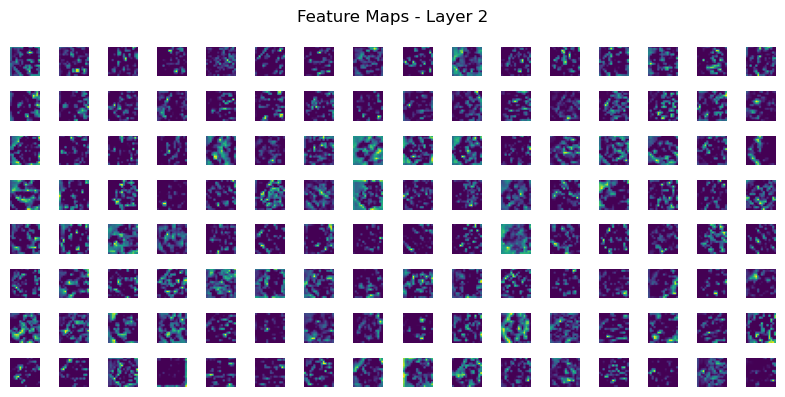

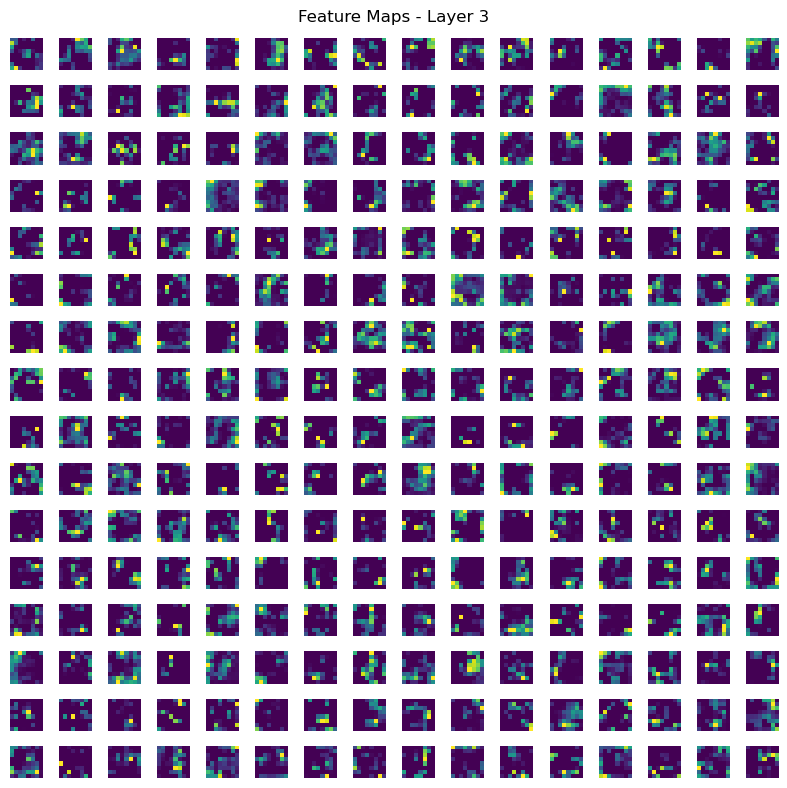

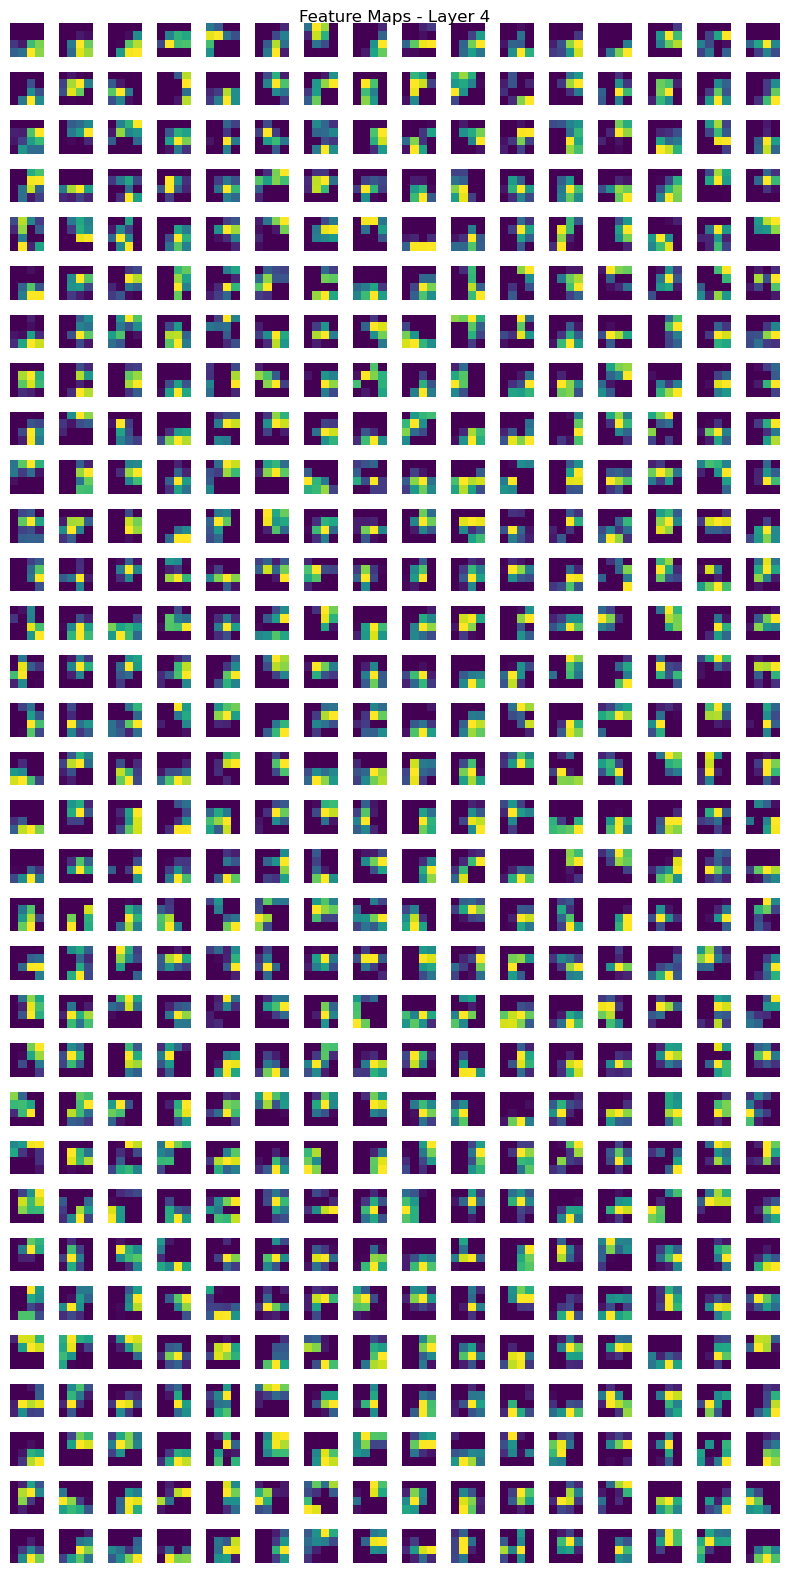

In [ ]:
x1, x2, x3, x4, output = model(input_image)

# def visualize_feature_maps(feature_maps, title, x, y):
#     num_maps = feature_maps.shape[1]
#     fig, axes = plt.subplots(1, num_maps, figsize=(x, y))
#     for i in range(num_maps):
#         axes[i].imshow(feature_maps[0, i].detach().cpu().numpy(), cmap='jet')  # Mover a CPU para visualizar
#         axes[i].axis('off')
#     plt.suptitle(title)
#     plt.show()

# visualize_feature_maps(x1, "Feature Maps - Layer 1", x=8, y=2)
# visualize_feature_maps(x2, "Feature Maps - Layer 2", x=8, y=2)
# visualize_feature_maps(x3, "Feature Maps - Layer 3", x=20, y=2)
# visualize_feature_maps(x4, "Feature Maps - Layer 4", x=20, y=2)

def visualize_all_feature_maps(feature_maps, title, max_columns=16, map_size=1):
    feature_maps = feature_maps[0].cpu().detach().numpy()  # Selecciona el primer ejemplo del batch
    num_maps = feature_maps.shape[0]  # Número total de mapas
    num_rows = (num_maps + max_columns - 1) // max_columns  # Número de filas necesarias

    plt.figure(figsize=(max_columns * map_size, num_rows * map_size))
    for i in range(num_maps):
        plt.subplot(num_rows, max_columns, i + 1)
        plt.imshow(feature_maps[i], cmap='viridis')
        plt.axis('off')
    plt.suptitle(title, fontsize=12)
    plt.tight_layout()
    plt.show()
    
visualize_all_feature_maps(x1, "Feature Maps - Layer 1", map_size=0.5)
visualize_all_feature_maps(x2, "Feature Maps - Layer 2", map_size=0.5)
visualize_all_feature_maps(x3, "Feature Maps - Layer 3", map_size=0.5)
visualize_all_feature_maps(x4, "Feature Maps - Layer 4", map_size=0.5)


In [42]:
def extract_features(data_loader, model, device):
    model.eval()
    features = []
    labels = []

    with torch.no_grad():
        for images, label_batch in data_loader:
            images = images.to(device)
            
            # Extraer las características del modelo
            _, _, _, fc1_out, _ = model(images)
            
            features.append(fc1_out.cpu().numpy())
            labels.append(label_batch.cpu().numpy())

    features = np.concatenate(features, axis=0)
    labels = np.concatenate(labels, axis=0)
    return features, labels

def visualize_nn_features(features, labels, data_loader, k=5, num_samples=5):
    # Ajustar modelo de vecinos más cercanos
    nbrs = NearestNeighbors(n_neighbors=k + 1, metric='euclidean').fit(features)  # +1 para incluir el propio punto
    distances, indices = nbrs.kneighbors(features)

    all_images = []
    for images, _ in data_loader:
        all_images.append(images)
    all_images = torch.cat(all_images, dim=0).numpy()

    sample_indices = np.random.choice(len(features), num_samples, replace=False)

    for idx in sample_indices:
        plt.figure(figsize=(15, 3))
        
        original_image = all_images[idx].transpose(1, 2, 0) * 0.5 + 0.5  # Desnormalizar
        plt.subplot(1, k + 2, 1)
        plt.imshow(original_image)
        plt.title(f"Original\nClass: {labels[idx]}")
        plt.axis('off')

        for neighbor_idx, neighbor in enumerate(indices[idx][1:]):  # Ignorar el propio punto
            neighbor_image = all_images[neighbor].transpose(1, 2, 0) * 0.5 + 0.5  # Desnormalizar
            plt.subplot(1, k + 2, neighbor_idx + 2)
            plt.imshow(neighbor_image)
            plt.title(f"Neighbor {neighbor_idx + 1}\nClass: {labels[neighbor]}")
            plt.axis('off')
        
        plt.tight_layout()
        plt.show()


features, labels = extract_features(train_dl, model, device)
visualize_nn_features(features, labels, train_dl, k=5, num_samples=3)

ValueError: Found array with dim 4. NearestNeighbors expected <= 2.

In [34]:
snails

NameError: name 'snails' is not defined